## Apprentissage par renforcement : epsilon-greedy vs UCB , LinUCB


Ce TME a pour objectif d'expérimenter les modèles UCB et LinUCB vus en cours pour
de la sélection de publicité en ligne.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In /home/yass/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/yass/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/yass/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/yass/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/yass/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

### Importation des données

In [2]:
def read_data(filename = "CTR.txt"):
    #data = []
    ids, x, r = [], [], []
    
    with open(filename, "r") as f:
        for line in f.readlines():
            n, repr, action_rewards = line.split(':')
            repr =  repr.strip().split(';') 
            action_rewards =  action_rewards.strip().split(';') 

            ids.append(n)
            x.append(repr)
            r.append(action_rewards)

    ids = np.array(ids).astype(int)
    x = np.array(x).astype(float)
    r = np.array(r).astype(float)
    
    return ids, x, r

In [3]:
ids, x, r = read_data()

In [4]:
ids.shape, x.shape, r.shape

((5000,), (5000, 5), (5000, 10))

In [5]:
ids

array([   0,    1,    2, ..., 4997, 4998, 4999])

### construction de l'environnement

In [64]:
class CTREnv:
    def __init__(self, filename="CTR.txt"):
        ids, x, r = read_data(filename=filename)
        self.ids = ids
        self.x = x
        self.r = r
        self.t = 0
        self.T = self.x.shape[0] # Temps final
        self.n_actions = self.r.shape[1]
    
    def start(self):
        return self.x[0]
        

    
    def is_end(self):
        return self.t >= self.T

    def step(self, a):
        t = self.t
        assert self.t < self.T, "la partie est terminée"
        assert a < self.n_actions, "les actions vont de 0 à {}. vous avez fourni {}".format(self.n_actions-1, a)

        reward = self.r[t, a]
        self.t += 1
        obs = self.x[t, :]

        return obs, reward, self.is_end()

In [11]:
env = CTREnv()

In [12]:
env.step(2)

(array([0.74837091, 0.83520778, 0.07669896, 0.17243899, 0.14344585]),
 0.0,
 False)

###  1) Baseline

In [40]:
class Policy:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.rewards = []
        self.cum_rewards = np.zeros(n_actions)
        self.counter = np.zeros(n_actions)+1

    def act(self, obs):
        pass
    def update(self, action, reward):
        self.counter[action] += 1
        self.cum_rewards[action] += reward
        self.rewards.append(reward) 



class RandomPolicy(Policy):

    def __init___(self):
        super().__init__(n_actions)

    def act(self, obs):
        a = np.random.randint(self.n_actions)
        return a


class StaticBest(Policy):
    def __init___(self):
        super().__init__(n_actions)

    def act(self, obs):
        a = np.argmax( self.cum_rewards ) 
        return a

class OptimalPolicy(Policy):
    def __init___(self):
        super().__init__(n_actions)

    def act(self, obs):
        a = np.argmax( np.divide(self.cum_rewards , self.counter) ) 
        return a
   

### 2) UCB:

In [41]:
class UcbPolicy(Policy):
    def __init__(self,n_actions):
        self.t = 0
        super().__init__(n_actions)
        

    def act(self, obs):
        self.t +=1
        a = np.argmax(np.divide(self.cum_rewards , self.counter)+
                      np.array([ (np.sqrt(2*np.log(self.t)/self.counter[i])) 
                                 for i in range( len(self.cum_rewards))])
                      ) 
        return a

In [75]:
class UcbLinPolicy(Policy):
    def __init__(self,n_actions,d, alpha):
        super().__init__(n_actions)

        self.t = 0
        self.d = d
        self.alpha = alpha
        self.A = [np.identity(d) for _ in range(n_actions)]
        self.b = [np.zeros((d, 1)) for _ in range(n_actions)]
        self.theta = [np.zeros((d, 1)) for _ in range(n_actions)]
        self.bound = np.zeros((n_actions, 1))
        

    def act(self, obs):
        obs = obs.reshape((self.d, 1))
        self.t += 1
        tmp = np.array( [np.dot( self.theta[a].T, obs ) for a in range(self.n_actions)] ).reshape((self.n_actions, 1))
        a = np.argmax( (tmp + self.bound).flatten() ) 
        self.prev_obs = obs
        return a

    def update(self, action, reward):
        obs=self.prev_obs
        super().update(action, reward)
        self.A[action] += np.dot(obs, obs.T)
        self.b[action] += reward*obs

        A_inv = np.linalg.inv(self.A[action])
        self.theta[action] = A_inv.dot( self.b[action] )
        self.bound[action]  = self.alpha * np.sqrt( obs.T.dot(A_inv).dot(obs) )




In [78]:
env = CTREnv()
policy = UcbLinPolicy(env.n_actions, 5, 10)

obs = env.start()

while True:
    a = policy.act(obs)
    obs, r, is_end = env.step(a)
    policy.update(a, r)
    if is_end:
        break

([<matplotlib.lines.Line2D at 0x7faae326ad68>], 0.016453225322725928)

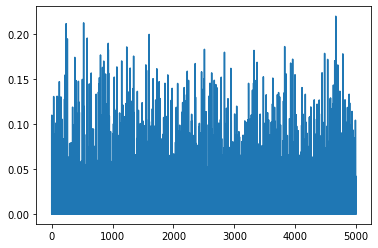

In [79]:
plt.plot(policy.rewards), np.mean(policy.rewards)

In [42]:
env = CTREnv()
policy = UcbPolicy(env.n_actions)

obs = env.start()

while True:
    a = policy.act(obs)
    obs, r, is_end = env.step(a)
    policy.update(a, r)
    if is_end:
        break

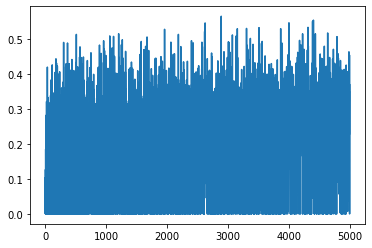

In [31]:
plt.plot(policy.rewards)

In [33]:
np.mean(policy.rewards)

0.20141435233039687

In [34]:
env = CTREnv()
policy = RandomPolicy(env.n_actions)

obs = env.start()

while True:
    a = policy.act(obs)
    obs, r, is_end = env.step(a)
    policy.update(a, r)
    if is_end:
        break

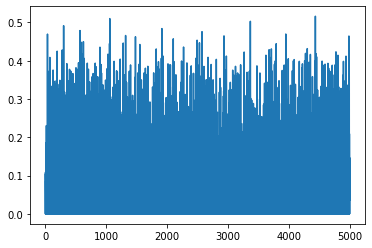

In [35]:
plt.plot(policy.rewards)

In [36]:
np.mean(policy.rewards)

0.0803476838949936

In [37]:
env = CTREnv()
policy = StaticBest(env.n_actions)

obs = env.start()

while True:
    a = policy.act(obs)
    obs, r, is_end = env.step(a)
    policy.update(a, r)
    if is_end:
        break

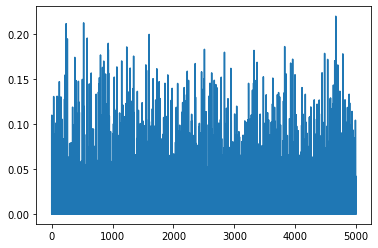

In [38]:
plt.plot(policy.rewards)

In [39]:
np.mean(policy.rewards)

0.016453225322725928